## Creating a Simple MODFLOW 6 Model with Flopy
https://flopy.readthedocs.io/en/stable/Notebooks/mf6_simple_model_example.html

In [1]:
import os
import sys
from pprint import pformat
from tempfile import TemporaryDirectory

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import flopy

print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.11.11 | packaged by conda-forge | (main, Dec  5 2024, 14:06:23) [MSC v.1942 64 bit (AMD64)]
numpy version: 2.0.2
matplotlib version: 3.9.4
flopy version: 3.8.2


In [2]:
# For this example, we will set up a temporary workspace.
# Model input files and output files will reside here.
temp_dir = TemporaryDirectory()
workspace = os.path.join(temp_dir.name, "mf6lake")

In [3]:
name = "mf6lake"
h1 = 100
h2 = 90
Nlay = 10
N = 101
L = 400.0
H = 50.0
k = 1.0

In [4]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name="mf6", version="mf6", sim_ws=workspace
)

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
)

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = f"{name}.nam"
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname="ims", complexity="SIMPLE")



In [5]:
# Create the discretization package
bot = np.linspace(-H / Nlay, -H, Nlay)
delrow = delcol = L / (N - 1)
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    gwf,
    pname="dis",
    nlay=Nlay,
    nrow=N,
    ncol=N,
    delr=delrow,
    delc=delcol,
    top=0.0,
    botm=bot,
)

In [6]:
# Create the initial conditions package
start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=start)

In [8]:
# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
    gwf, pname="npf", icelltype=1, k=k, save_flows=True
)

In [9]:
# Create the constant head package.
# List information is created a bit differently for
# MODFLOW 6 than for other MODFLOW versions.  The
# cellid (layer, row, column, for a regular grid)
# must be entered as a tuple as the first entry.
# Remember that these must be zero-based indices!
chd_rec = []
chd_rec.append(((0, int(N / 2), int(N / 2)), h2))
for layer in range(0, Nlay):
    for row_col in range(0, N):
        chd_rec.append(((layer, row_col, 0), h1))
        chd_rec.append(((layer, row_col, N - 1), h1))
        if row_col != 0 and row_col != N - 1:
            chd_rec.append(((layer, 0, row_col), h1))
            chd_rec.append(((layer, N - 1, row_col), h1))
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(
    gwf,
    pname="chd",
    maxbound=len(chd_rec),
    stress_period_data=chd_rec,
    save_flows=True,
)

In [10]:
# The chd package stored the constant heads in a structured
# array, also called a recarray.  We can get a pointer to the
# recarray for the first stress period (iper = 0) as follows.
iper = 0
ra = chd.stress_period_data.get_data(key=iper)
ra



rec.array([((0, 50, 50),  90), ((0, 0, 0), 100), ((0, 0, 100), 100), ...,
           ((9, 100, 99), 100), ((9, 100, 0), 100), ((9, 100, 100), 100)],
          dtype=[('cellid', 'O'), ('head', '<i8')])

Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

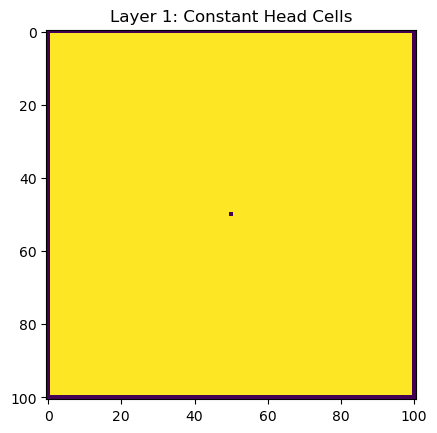

In [11]:
# We can make a quick plot to show where our constant
# heads are located by creating an integer array
# that starts with ones everywhere, but is assigned
# a -1 where chds are located
ibd = np.ones((Nlay, N, N), dtype=int)
for k, i, j in ra["cellid"]:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation="none")
plt.title(f"Layer {ilay + 1}: Constant Head Cells")

In [12]:
# Create the output control package
headfile = f"{name}.hds"
head_filerecord = [headfile]
budgetfile = f"{name}.cbb"
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)



### Note that help can always be found for a package
### using either forms of the following syntax
help(oc)
### help(flopy.mf6.modflow.mfgwfoc.ModflowGwfoc)

In [13]:
# Write the datasets
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model mf6lake...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
    writing package oc...


In [14]:
# Print a list of the files that were created
# in workspace
print(os.listdir(workspace))

['mf6lake.chd', 'mf6lake.dis', 'mf6lake.ic', 'mf6lake.ims', 'mf6lake.nam', 'mf6lake.npf', 'mf6lake.oc', 'mf6lake.tdis', 'mfsim.nam']


In [15]:
# Run the simulation
success, buff = sim.run_simulation(silent=True, report=True)
assert success, pformat(buff)

(np.float64(0.0), np.float64(400.0), np.float64(0.0), np.float64(400.0))

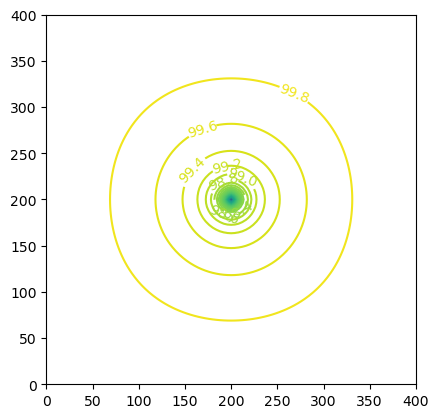

In [16]:
# Read the binary head file and plot the results
# We can use the existing Flopy HeadFile class because
# the format of the headfile for MODFLOW 6 is the same
# as for previous MODFLOW verions
fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, L, N)
y = y[::-1]
c = plt.contour(x, y, h[0], np.arange(90, 100.1, 0.2))
plt.clabel(c, fmt="%2.1f")
plt.axis("scaled")

(np.float64(0.0), np.float64(400.0), np.float64(0.0), np.float64(400.0))

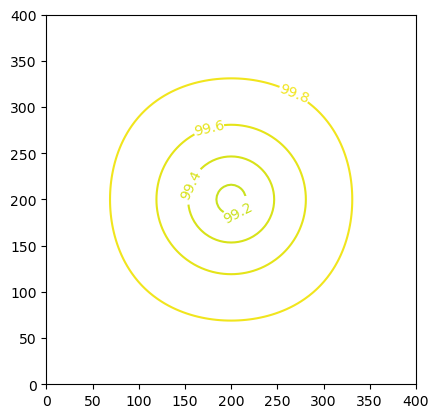

In [17]:
x = y = np.linspace(0, L, N)
y = y[::-1]
c = plt.contour(x, y, h[-1], np.arange(90, 100.1, 0.2))
plt.clabel(c, fmt="%1.1f")
plt.axis("scaled")



(np.float64(0.0), np.float64(400.0), np.float64(-47.5), np.float64(-2.5))

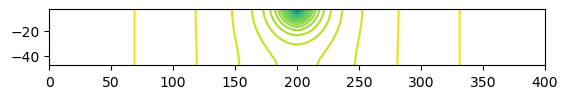

In [18]:
z = np.linspace(-H / Nlay / 2, -H + H / Nlay / 2, Nlay)
c = plt.contour(x, z, h[:, 50, :], np.arange(90, 100.1, 0.2))
plt.axis("scaled")

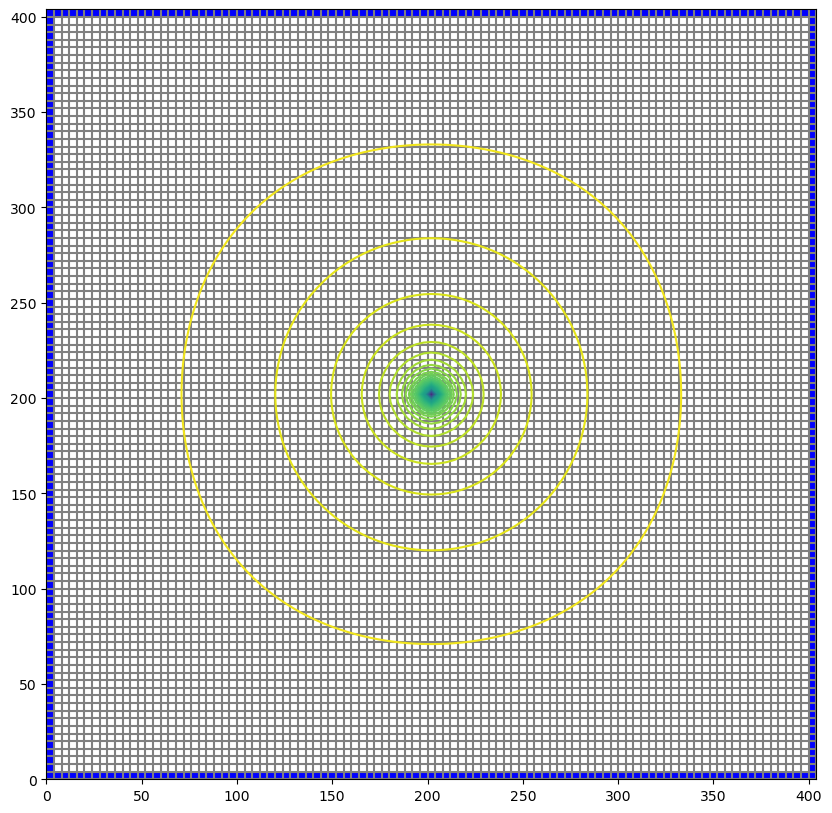

In [19]:
# We can also use the Flopy PlotMapView capabilities for MODFLOW 6
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
quadmesh = modelmap.plot_ibound(ibound=ibd)
linecollection = modelmap.plot_grid()
contours = modelmap.contour_array(h[0], levels=np.arange(90, 100.1, 0.2))

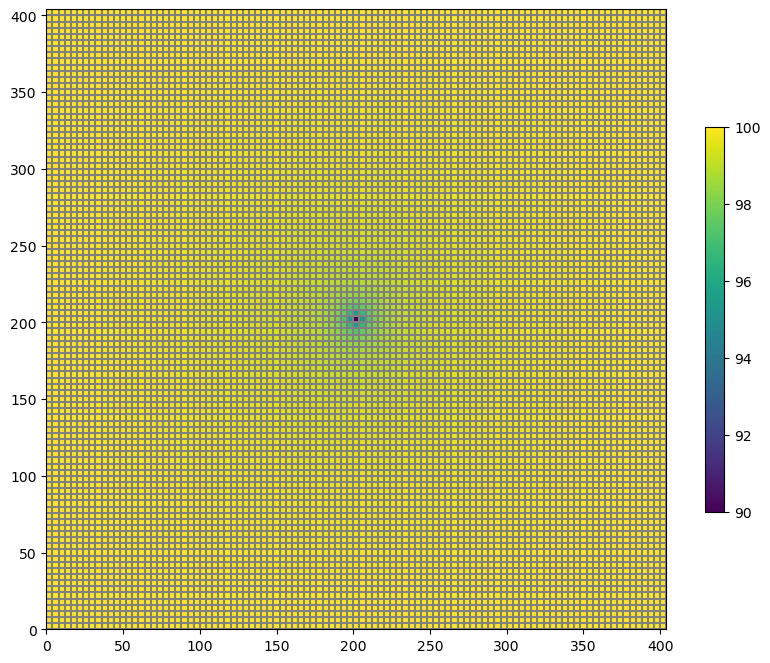

In [20]:
# We can also use the Flopy PlotMapView capabilities for MODFLOW 6
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Next we create an instance of the ModelMap class
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
quadmesh = modelmap.plot_ibound(ibound=ibd)
linecollection = modelmap.plot_grid()
pa = modelmap.plot_array(h[0])
cb = plt.colorbar(pa, shrink=0.5)

In [21]:
# read the binary grid file
fname = os.path.join(workspace, f"{name}.dis.grb")
bgf = flopy.mf6.utils.MfGrdFile(fname)

# data read from the binary grid file is stored in a dictionary
bgf._datadict



{'NCELLS': np.int32(102010),
 'NLAY': np.int32(10),
 'NROW': np.int32(101),
 'NCOL': np.int32(101),
 'NJA': np.int32(689628),
 'XORIGIN': np.float64(0.0),
 'YORIGIN': np.float64(0.0),
 'ANGROT': np.float64(0.0),
 'DELR': array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]),
 'DELC': array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4.

In [22]:
# read the cell budget file
fname = os.path.join(workspace, f"{name}.cbb")
cbb = flopy.utils.CellBudgetFile(fname, precision="double")
cbb.headers.T

,64,5517216
kstp,1,1
kper,1,1
text,FLOW-JA-FACE,CHD
ncol,689628,101
nrow,1,101
nlay,-1,-10
imeth,1,6
delt,1.0,1.0
pertim,1.0,1.0
totim,1.0,1.0


In [23]:
flowja = cbb.get_data(text="FLOW-JA-FACE")[0][0, 0, :]
chdflow = cbb.get_data(text="CHD")[0]

In [24]:
# By having the ia and ja arrays and the flow-ja-face we can look at
# the flows for any cell and process them in the follow manner.
k = 5
i = 50
j = 50
celln = k * N * N + i * N + j
ia, ja = bgf.ia, bgf.ja
print(f"Printing flows for cell {celln}")
for ipos in range(ia[celln] + 1, ia[celln + 1]):
    cellm = ja[ipos]
    print(f"Cell {celln} flow with cell {cellm} is {flowja[ipos]}")

Printing flows for cell 56105
Cell 56105 flow with cell 45904 is -0.5173461773371856
Cell 56105 flow with cell 56004 is 0.04821245255698159
Cell 56105 flow with cell 56104 is 0.04821245255698159
Cell 56105 flow with cell 56106 is 0.04827345085914203
Cell 56105 flow with cell 56206 is 0.04827345085914203
Cell 56105 flow with cell 66306 is 0.32526484558511587


In [25]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass